In [ ]:
from psi import FeatureSelectionPipeline
from psi.feature_selection import LassoFeatureSelection
from psi import Data
from psi.test_statistics import SFS_DATestStatistic
from psi.domain_adaptation import OptimalTransportDA
import numpy as np
import matplotlib.pyplot as plt

d:\Workspace\Research\StatiscalLearning\PythonSI\PythonSI\util\line_search.py:29: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(list_intervals[i][1] <= list_intervals[i+1][0], "Intervals are overlapping in line search")


In [ ]:
def SFS_DA() -> FeatureSelectionPipeline:
    r"""Sequential Feature Selection with Domain Adaptation pipeline.
    
    This function constructs a feature selection pipeline that applies
    optimal transport domain adaptation between source and target domains,
    followed by LASSO feature selection on the adapted data.
    
    The pipeline implements the following workflow:
    
    1. Apply optimal transport domain adaptation: :math:`(\tilde{\mathbf{x}}, \tilde{\mathbf{y}}) = OT(\mathbf{x}_s, \mathbf{y}_s, \mathbf{x}_t, \mathbf{y}_t)`
    2. Perform LASSO feature selection on adapted data
    3. Compute selective inference statistics
    
    Returns
    -------
    pipeline : FeatureSelectionPipeline
        Configured feature selection pipeline with domain adaptation
        
    Notes
    -----
    The pipeline uses empty Data nodes that need to be populated with
    actual data before execution. The LASSO regularization parameter
    is set to :math:`\lambda = 10`.
    
    Examples
    --------
    >>> pipeline = SFS_DA()
    >>> # Populate with actual data and run
    >>> results = pipeline(inputs=[xs_data, ys_data, xt_data, yt_data])
    """
    xs = Data()
    ys = Data() 
    
    xt = Data()
    yt = Data()
    
    OT = OptimalTransportDA()
    x_tilde, y_tilde = OT.run(xs=xs, ys=ys, xt=xt, yt=yt)

    lasso = LassoFeatureSelection(lambda_=10)
    active_set = lasso.run(x_tilde, y_tilde)
    return FeatureSelectionPipeline(inputs=(xs, ys, xt, yt), output=active_set, test_statistic=SFS_DATestStatistic(xs=xs, ys=ys, xt=xt, yt=yt))

In [ ]:
def gen_data(n, p, true_beta):
    r"""Generate synthetic linear regression data for testing.
    
    Creates a dataset following the linear model:
    
    .. math::
        \mathbf{Y} = \mathbf{x} \boldsymbol{\beta} + \boldsymbol{\epsilon}
    
    where:
    
    - :math:`\mathbf{x} \in \mathbb{R}^{n \times p}` with :math:`x_{ij} \sim \mathcal{N}(0, 1)`
    - :math:`\boldsymbol{\beta} \in \mathbb{R}^p` is the true coefficient vector
    - :math:`\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}_n)` is the noise vector
    
    Parameters
    ----------
    n : int
        Number of samples to generate
    p : int
        Number of features (dimensions)
    true_beta : array-like, shape (p,)
        True coefficient vector for linear relationship
        
    Returns
    -------
    x : array-like, shape (n, p)
        Feature matrix with entries drawn from standard normal distribution
    Y : array-like, shape (n, 1)
        Response vector following the linear model
    Sigma : array-like, shape (n, n)
        Identity covariance matrix for the noise
        
    Examples
    --------
    >>> beta = np.array([1, 0, -2, 0, 0.5])
    >>> x, Y, Sigma = gen_data(100, 5, beta)
    >>> print(x.shape)  # (100, 5)
    >>> print(Y.shape)  # (100, 1)
    """
    x = np.random.normal(loc = 0, scale = 1, size = (n, p))
    true_beta = true_beta.reshape(-1, 1)
    
    mu = x.dot(true_beta)
    Sigma = np.identity(n)
    Y = mu + np.random.normal(loc = 0, scale = 1, size = (n, 1))
    return x, Y, Sigma

In [ ]:
my_pipeline = SFS_DA()

num_iters = 1
list_p_value = []
for _ in range(num_iters):
    xs, ys, sigma_s = gen_data(150, 5, np.asarray([0, 0, 0, 0, 0]))
    xt, yt, sigma_t = gen_data(25, 5, np.asarray([0, 0, 0, 0, 0]))
    selected_features, p_values = my_pipeline(inputs=[xs, ys, xt, yt], sigmas=[sigma_s, sigma_t], verbose=True)
    list_p_value.extend(p_values)

Selected feature: [0 1 2 3 4]
Testing feature 0
Feature 0: p-value = 0.26171270900074967
Testing feature 1
Feature 1: p-value = 0.4187634650910885
Testing feature 2
Feature 2: p-value = 0.810785830449716
Testing feature 3
Feature 3: p-value = 0.3059128627144949
Testing feature 4
Feature 4: p-value = 0.43593884832779817


In [5]:
print(selected_features)
print(p_values)

[0 1 2 3 4]
[0.26171270900074967, 0.4187634650910885, 0.810785830449716, 0.3059128627144949, 0.43593884832779817]


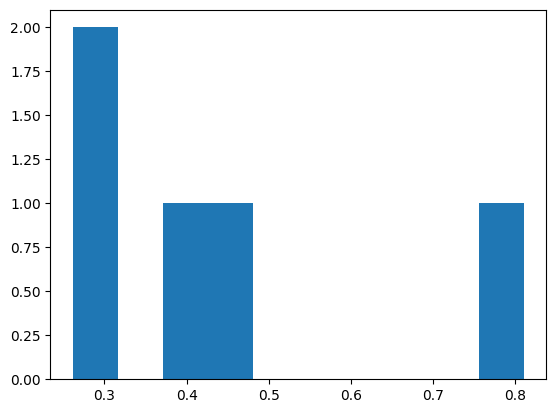

In [6]:
plt.hist(list_p_value)
plt.show()